In [20]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
rcParams['figure.figsize'] = 15, 10

### 1. Чтение данных из excel-файла

In [5]:
data = pd.read_excel('Данные.xlsx', index_col='Date',parse_dates=['Date'], 
                      engine="openpyxl")
data.sort_values('Date', ascending = True)
data = data.dropna(axis = 1)
print(data)
print (data.isna().sum())

              Value
Date               
1959-01-01  22.8331
1959-02-01  23.2802
1959-03-01  23.6156
1959-04-01  24.1186
1959-05-01  24.4820
...             ...
1988-08-01  63.8851
1988-09-01  63.7040
1988-10-01  64.0220
1988-11-01  64.1173
1988-12-01  64.4210

[360 rows x 1 columns]
Value    0
dtype: int64


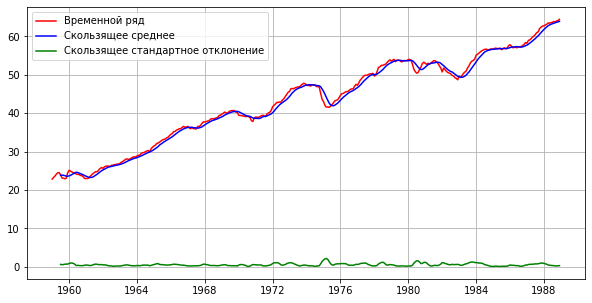

In [6]:
#рисуем график ряда
plt.figure(figsize=(10,5))
plt.plot(data.Value,'red', label='Временной ряд')
plt.plot(data.Value.rolling(window=7).mean(), 'blue', 
                            label='Скользящее среднее')
plt.plot(data.Value.rolling(window=7).std(), 'green', 
                            label='Скользящее стандартное отклонение')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

Есть тренд - ряд не стационарный. Далее проведем более точный (не визуальный) анализ ряда на стационарность с помощью теста Дики-Фуллера

In [7]:
# Тест Дики-Фуллера
def aug_dickey_fuller(y):
    test = sm.tsa.adfuller(y)
    print ('adf: ', test[0]) 
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if (test[0]> test[4]['5%']): 
        print ('есть единичные корни, ряд не стационарен')
        return False
    else:
        print ('единичных корней нет, ряд стационарен')
        return True

In [8]:
aug_dickey_fuller(data.Value)

adf:  -0.25339117992846055
p-value:  0.9318510422993468
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
есть единичные корни, ряд не стационарен


False

### 2. Разложение временного ряда на тренд, сезональность, остаток

#### Разложение ряда в соответствии с аддитивной моделью

<Figure size 1080x720 with 0 Axes>

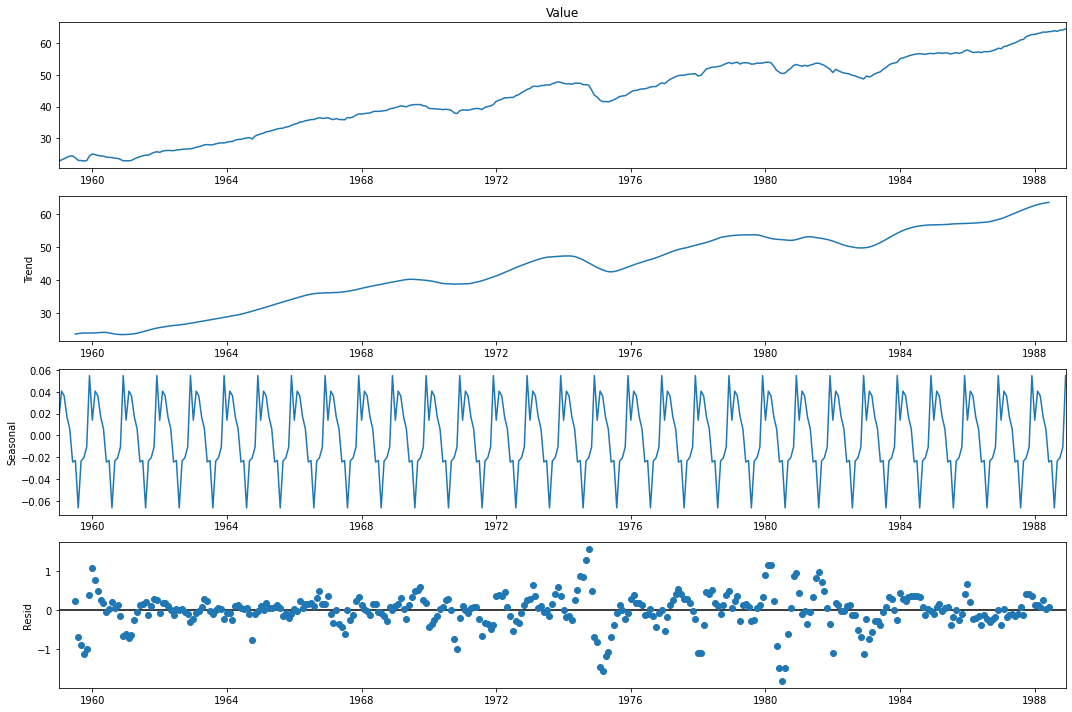

In [9]:
plt.clf()
add = sm.tsa.seasonal_decompose(data.Value, 'additive')
add.plot()
plt.show()

In [10]:
print("ТРЕНД")
aug_dickey_fuller(add.trend.dropna())
print("СЕЗОНАЛЬНОСТЬ")
aug_dickey_fuller(add.seasonal.dropna())
print("ОСТАТОК")
aug_dickey_fuller(add.resid.dropna())

ТРЕНД
adf:  -0.8615760333582281
p-value:  0.8003625761532782
Critical values:  {'1%': -3.4503224123605194, '5%': -2.870338478726661, '10%': -2.571457612488522}
есть единичные корни, ряд не стационарен
СЕЗОНАЛЬНОСТЬ
adf:  -340632554252990.56
p-value:  0.0
Critical values:  {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}
единичных корней нет, ряд стационарен
ОСТАТОК
adf:  -7.485563833765421
p-value:  4.6490966746941735e-11
Critical values:  {'1%': -3.4496162602188187, '5%': -2.870028369720798, '10%': -2.5712922615505627}
единичных корней нет, ряд стационарен


True

#### Разложение ряда в соответствии с мультипликативной моделью

<Figure size 1080x720 with 0 Axes>

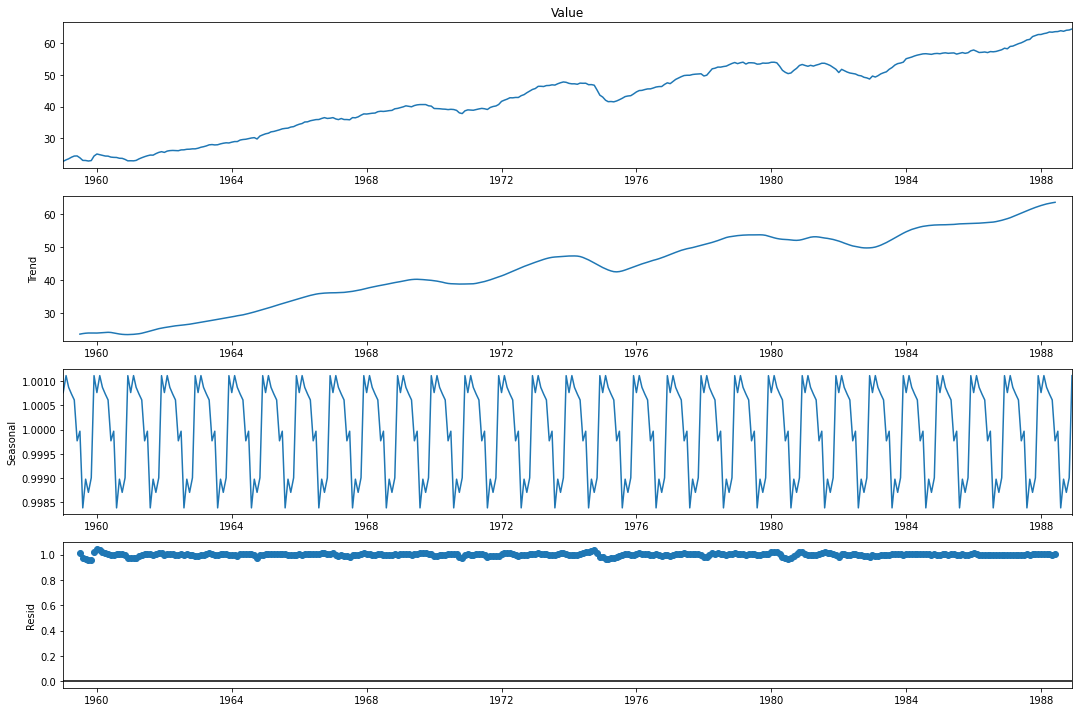

In [11]:
plt.clf()
mult = sm.tsa.seasonal_decompose(data.Value, 'multiplicate')
mult.plot()
plt.show()

In [12]:
print("ТРЕНД")
aug_dickey_fuller(mult.trend.dropna())
print("СЕЗОНАЛЬНОСТЬ")
aug_dickey_fuller(mult.seasonal.dropna())
print("ОСТАТОК")
aug_dickey_fuller(mult.resid.dropna())

ТРЕНД
adf:  -0.8615760333582281
p-value:  0.8003625761532782
Critical values:  {'1%': -3.4503224123605194, '5%': -2.870338478726661, '10%': -2.571457612488522}
есть единичные корни, ряд не стационарен
СЕЗОНАЛЬНОСТЬ
adf:  -54233897650363.51
p-value:  0.0
Critical values:  {'1%': -3.4494474563375737, '5%': -2.8699542285903887, '10%': -2.5712527305187987}
единичных корней нет, ряд стационарен
ОСТАТОК
adf:  -7.466083739785146
p-value:  5.200193898327597e-11
Critical values:  {'1%': -3.4496162602188187, '5%': -2.870028369720798, '10%': -2.5712922615505627}
единичных корней нет, ряд стационарен


True

### 3. Определение порядка интегрированности временного ряда

In [13]:
# функция определения порядка интегрированности временного ряда
def order(y):
    time_series = y
    order = 0
    while (not aug_dickey_fuller(time_series)):
        order += 1
        time_series = time_series.diff().dropna()
    return order

In [14]:
time_series = data.Value
order = order(time_series)
print("Порядок интегрированности - ", order)

adf:  -0.25339117992846055
p-value:  0.9318510422993468
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
есть единичные корни, ряд не стационарен
adf:  -7.3673114952119825
p-value:  9.164149561098284e-11
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
единичных корней нет, ряд стационарен
Порядок интегрированности -  1


###### Так как порядок интегрированности - 1, применим к данному временному ряду модель ARIMA

###### Подберем необходимые параметры

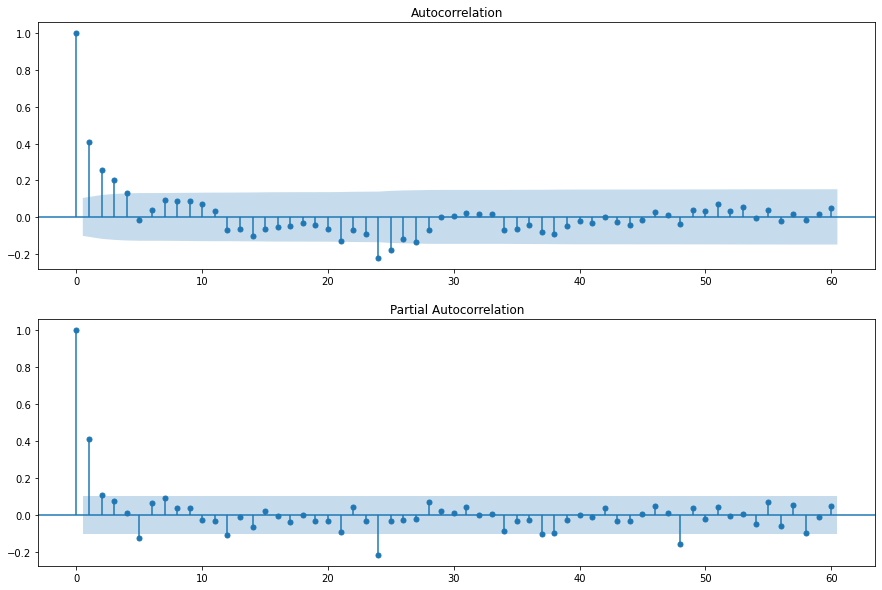

In [15]:
time_series = data.Value.diff(periods=1).dropna()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(time_series, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(time_series, lags=60, ax=ax2)

In [16]:
data_test = pd.read_excel('Ответы.xlsx', index_col='Date',
                          parse_dates=['Date'], engine="openpyxl")
data_test.sort_values('Date', ascending=True)
data_test = data_test.dropna(axis=1)
print (data_test.isna().sum())

Value    0
dtype: int64


In [17]:
def arima(data, order, test):
    model = sm.tsa.ARIMA(data, order=order, freq='MS').fit()
    pred = model.predict(start=data.shape[0], 
                         end=data.shape[0]+test.shape[0]-1, typ='levels')
    plt.clf()
    plt.plot(data_test.Value, 'blue', label='anwer')
    plt.plot(pred, 'red', label='pred' + str(order))
    plt.legend(loc='upper left')
    plt.show()
    print("R2-metrics", r2_score(pred, test))
    print("AIC :", model.aic)
    print(model.summary())
    return pred
     

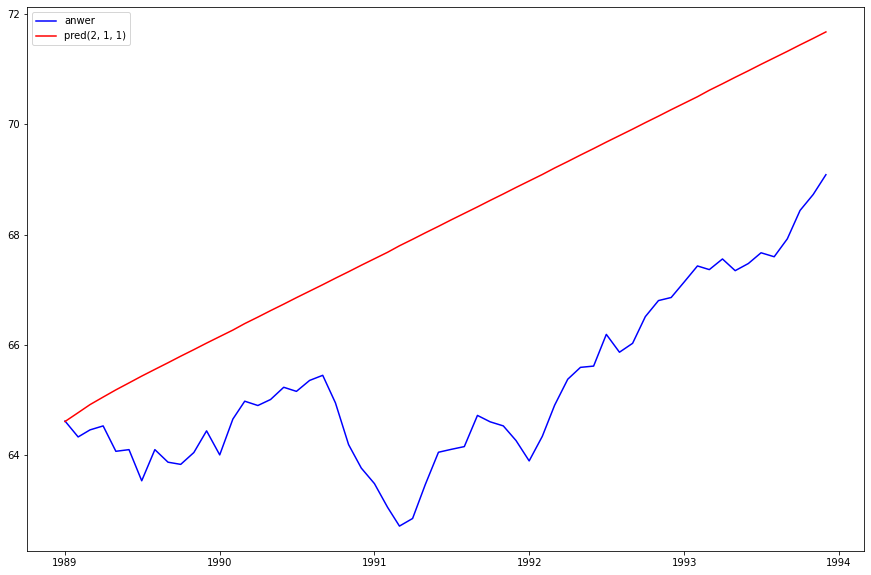

R2-metrics -1.4790471536740228
AIC : 250.66172836073906
                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -120.331
Method:                       css-mle   S.D. of innovations              0.338
Date:                Sat, 11 Dec 2021   AIC                            250.662
Time:                        12:26:17   BIC                            270.078
Sample:                    02-01-1959   HQIC                           258.383
                         - 12-01-1988                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1177      0.036      3.240      0.001       0.046       0.189
ar.L1.D.Value     0.7313      0.311      2.354      0.019       0.

In [18]:
pred1 = arima(data, (2,1,1), data_test)

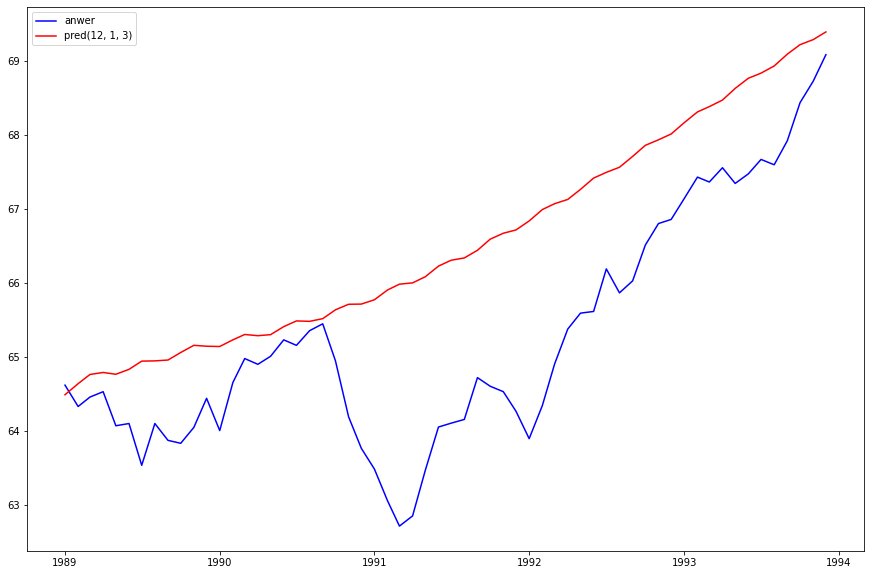

R2-metrics -0.1509168294579264
AIC : 248.80204453595502
                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                ARIMA(12, 1, 3)   Log Likelihood                -107.401
Method:                       css-mle   S.D. of innovations              0.323
Date:                Sat, 11 Dec 2021   AIC                            248.802
Time:                        12:31:33   BIC                            314.819
Sample:                    02-01-1959   HQIC                           275.054
                         - 12-01-1988                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1092      0.005     20.325      0.000       0.099       0.120
ar.L1.D.Value      1.2591      0.054     23.469      0.000     

In [21]:
pred2 = arima(data, (12, 1, 3), data_test)

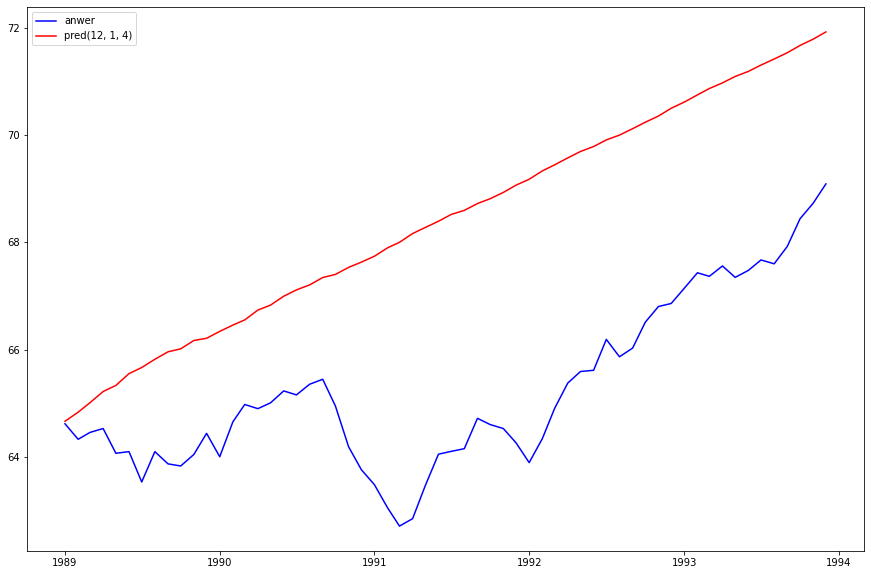

R2-metrics -1.7573658939452916
AIC : 250.59925682857693
                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                ARIMA(12, 1, 4)   Log Likelihood                -107.300
Method:                       css-mle   S.D. of innovations              0.325
Date:                Sat, 11 Dec 2021   AIC                            250.599
Time:                        12:32:45   BIC                            320.499
Sample:                    02-01-1959   HQIC                           278.396
                         - 12-01-1988                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1179      0.036      3.244      0.001       0.047       0.189
ar.L1.D.Value      0.3520      0.068      5.202      0.000     

In [22]:
pred3 = arima(data, (12, 1, 4), data_test)

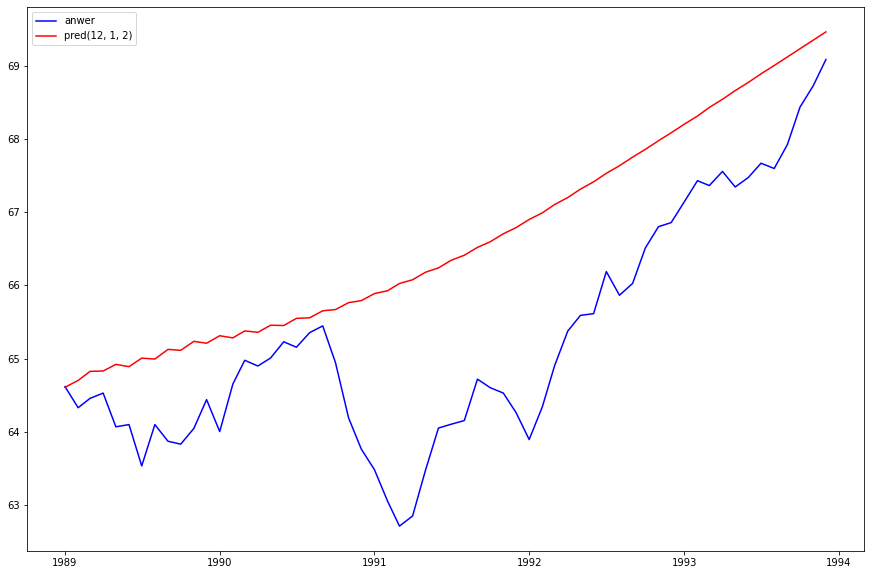

R2-metrics -0.2519476486113299
AIC : 245.70539786877384
                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                ARIMA(12, 1, 2)   Log Likelihood                -106.853
Method:                       css-mle   S.D. of innovations              0.323
Date:                Sat, 11 Dec 2021   AIC                            245.705
Time:                        12:40:29   BIC                            307.839
Sample:                    02-01-1959   HQIC                           270.413
                         - 12-01-1988                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1092      0.005     20.414      0.000       0.099       0.120
ar.L1.D.Value      0.3458      0.053      6.553      0.000     

In [23]:
pred4 = arima(data, (12, 1, 2), data_test)

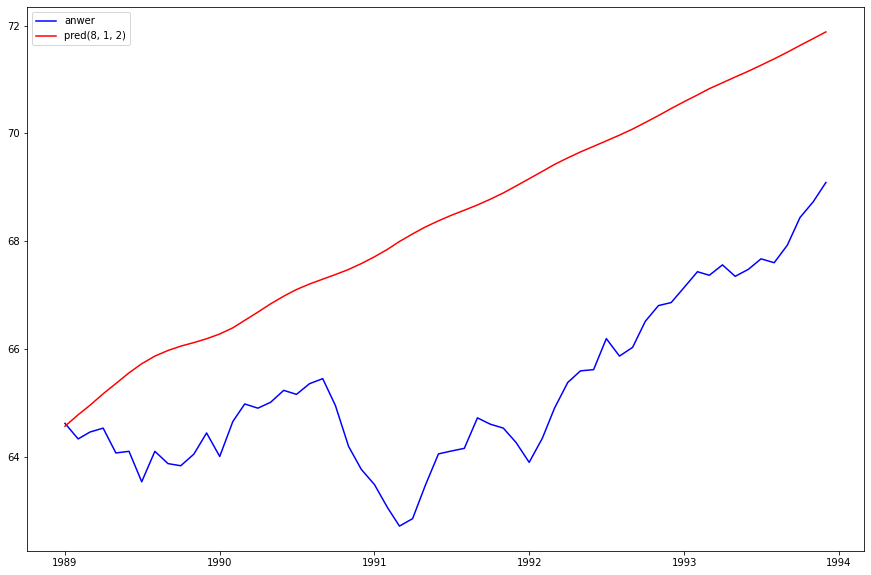

R2-metrics -1.7247110063747306
AIC : 243.39070583778255
                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                 ARIMA(8, 1, 2)   Log Likelihood                -109.695
Method:                       css-mle   S.D. of innovations              0.328
Date:                Sat, 11 Dec 2021   AIC                            243.391
Time:                        12:40:44   BIC                            289.991
Sample:                    02-01-1959   HQIC                           261.922
                         - 12-01-1988                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1178      0.035      3.344      0.001       0.049       0.187
ar.L1.D.Value     1.9948      0.067     29.664      0.000       1.

In [24]:
pred5 = arima(data, (8, 1, 2), data_test)

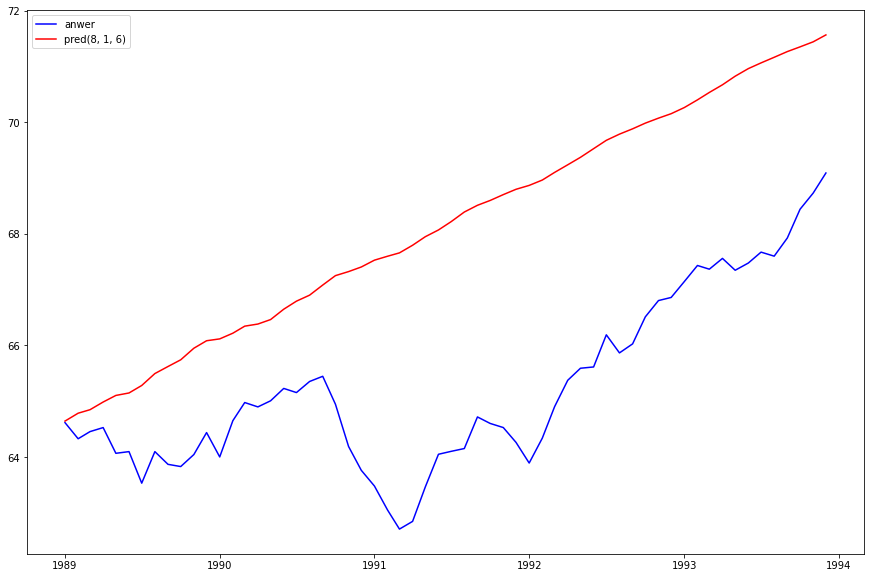

R2-metrics -1.4082180985214716
AIC : 242.73890550747944
                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                 ARIMA(8, 1, 6)   Log Likelihood                -105.369
Method:                       css-mle   S.D. of innovations              0.321
Date:                Sat, 11 Dec 2021   AIC                            242.739
Time:                        12:41:15   BIC                            304.872
Sample:                    02-01-1959   HQIC                           267.447
                         - 12-01-1988                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1172      0.038      3.088      0.002       0.043       0.192
ar.L1.D.Value     0.9339      0.136      6.886      0.000       0.

In [25]:
pred6 = arima(data, (8, 1, 6), data_test)

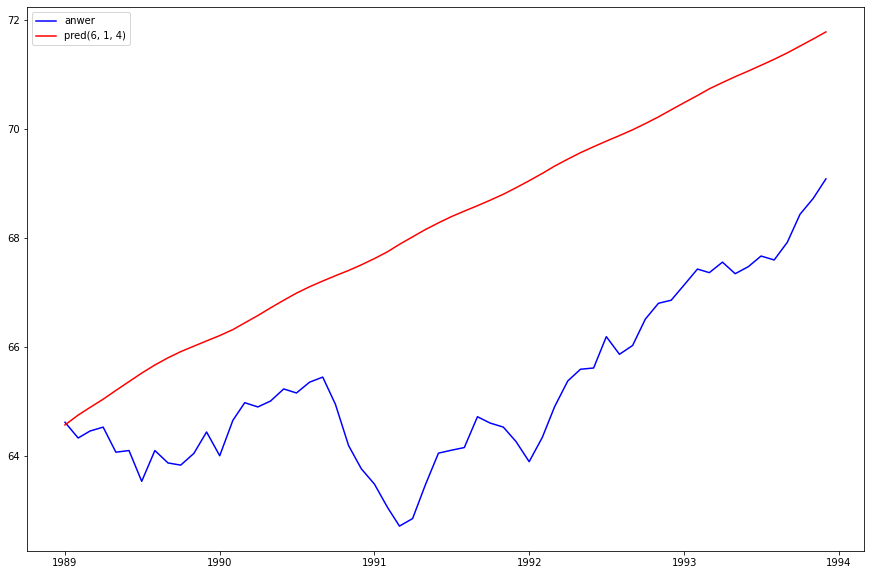

R2-metrics -1.5715781302946659
AIC : 244.18174915618874
                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                 ARIMA(6, 1, 4)   Log Likelihood                -110.091
Method:                       css-mle   S.D. of innovations              0.328
Date:                Sat, 11 Dec 2021   AIC                            244.182
Time:                        12:41:55   BIC                            290.782
Sample:                    02-01-1959   HQIC                           262.713
                         - 12-01-1988                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1177      0.039      3.002      0.003       0.041       0.195
ar.L1.D.Value     1.4325      0.273      5.243      0.000       0.

In [26]:
pred7 = arima(data, (6, 1, 4), data_test)

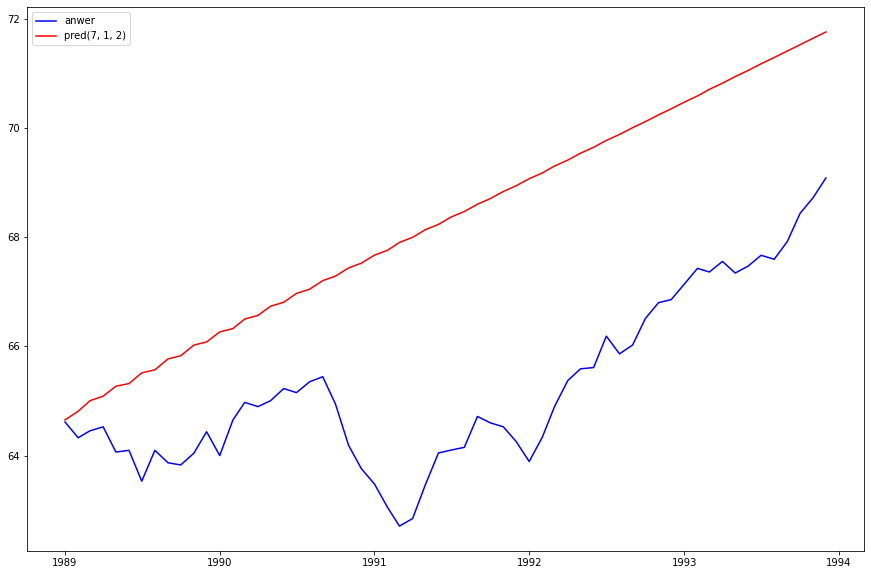

R2-metrics -1.5903403189511933
AIC : 246.3482697888171
                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                 ARIMA(7, 1, 2)   Log Likelihood                -112.174
Method:                       css-mle   S.D. of innovations              0.329
Date:                Sat, 11 Dec 2021   AIC                            246.348
Time:                        12:42:10   BIC                            289.065
Sample:                    02-01-1959   HQIC                           263.335
                         - 12-01-1988                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1173      0.039      3.001      0.003       0.041       0.194
ar.L1.D.Value    -0.0949      0.214     -0.444      0.657      -0.5

In [27]:
pred8 = arima(data, (7, 1, 2), data_test)

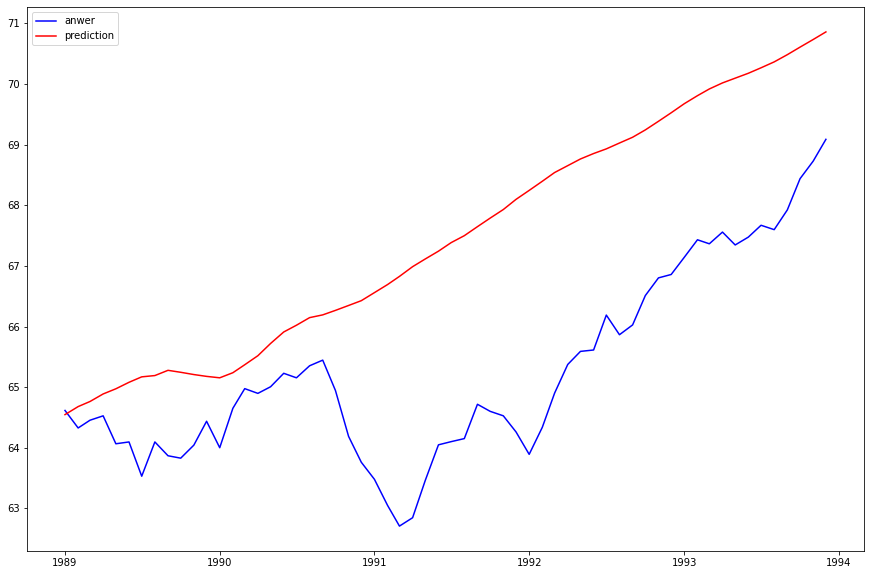

R2-metrics -0.6501415818991965
AIC : 260.9496266294136
                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                ARIMA(25, 1, 4)   Log Likelihood                 -99.475
Method:                       css-mle   S.D. of innovations              0.316
Date:                Sat, 11 Dec 2021   AIC                            260.950
Time:                        11:17:18   BIC                            381.333
Sample:                    02-01-1959   HQIC                           308.821
                         - 12-01-1988                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1160      0.024      4.863      0.000       0.069       0.163
ar.L1.D.Value      0.5357      0.068      7.847      0.000      

In [29]:
pred9 = arima(data, (25, 1, 4), data_test)

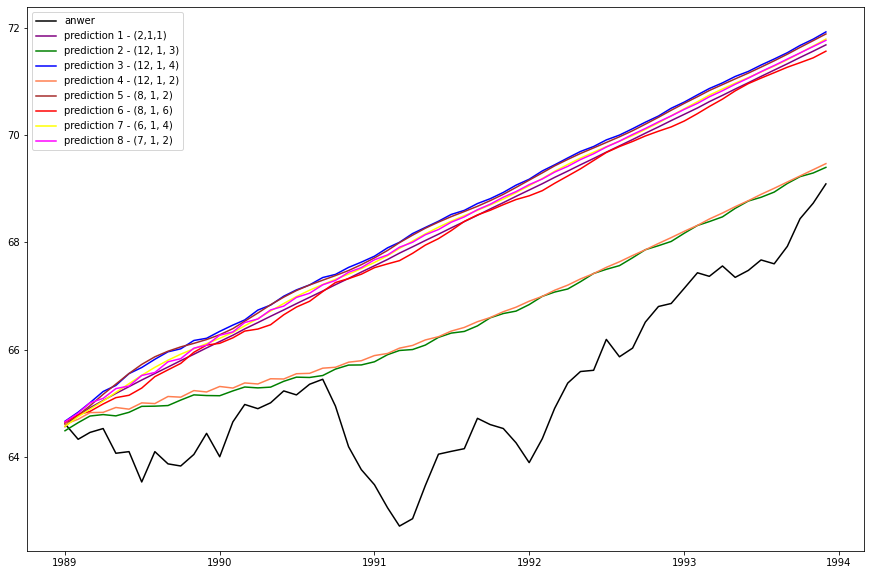

In [28]:
plt.plot(data_test.Value, 'black', label='anwer')
plt.plot(pred1, 'purple', label='prediction 1 - (2,1,1)')
plt.plot(pred2, 'green', label='prediction 2 - (12, 1, 3)')
plt.plot(pred3, 'blue', label='prediction 3 - (12, 1, 4)')
plt.plot(pred4, 'coral', label='prediction 4 - (12, 1, 2)')
plt.plot(pred5, 'brown', label='prediction 5 - (8, 1, 2)')
plt.plot(pred6, 'red', label='prediction 6 - (8, 1, 6)')
plt.plot(pred7, 'yellow', label='prediction 7 - (6, 1, 4)')
plt.plot(pred8, 'magenta', label='prediction 8 - (7, 1, 2)')
plt.legend(loc='upper left')
plt.show()

### Выводы

Если проанализовать проведенные выше тесты ARIMA-модели на разных (9) наборах параметров, то можно увидеть, что наилучшее (наименьшее) значение AIC было получено для ARIMA - модели с параметрами (8, 1, 6)(красный график).